In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

file_path = '/content/drive/My Drive/QVI_data.csv'
data = pd.read_csv(file_path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LYLTY_CARD_NBR,264834.0,135548.793331,80579.898912,1000.0,70021.0,130357.0,203094.00,2373711.0
STORE_NBR,264834.0,135.079423,76.784063,1.0,70.0,130.0,203.00,272.0
TXN_ID,264834.0,135157.623236,78132.920436,1.0,67600.5,135136.5,202699.75,2415841.0
PROD_NBR,264834.0,56.583554,32.826444,1.0,28.0,56.0,85.00,114.0
PROD_QTY,264834.0,1.905813,0.343436,1.0,2.0,2.0,2.00,5.0
TOT_SALES,264834.0,7.299346,2.527241,1.5,5.4,7.4,9.20,29.5
PACK_SIZE,264834.0,182.425512,64.325148,70.0,150.0,170.0,175.00,380.0


In [ ]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [ ]:
#data['YEARMONTH'] = data['DATE'].dt.strftime('%Y-%m')

In [ ]:
# Create YEARMONTH column (YYYYMM format)
data["YEARMONTH"] = data["DATE"].dt.year * 100 + data["DATE"].dt.month

# Display the first few rows
print(data[["DATE", "YEARMONTH"]].head())

        DATE  YEARMONTH
0 2018-10-17     201810
1 2018-09-16     201809
2 2019-03-07     201903
3 2019-03-08     201903
4 2018-11-02     201811


In [ ]:
data.head(3)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903


**SELECT CONTRTOL STORES**

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :

• Monthly overall sales revenue

• Monthly number of customers

• Monthly number of transactions per customer

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [ ]:
import pandas as pd

# Group by store and year-month, then aggregate required metrics
measure_over_time = data.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),
    nCustomers=("LYLTY_CARD_NBR", pd.Series.nunique),
    nTxnPerCust=("TXN_ID", "nunique"),
    nChipsPerTxn=("PROD_QTY", "sum"),
    avgPricePerUnit=("TOT_SALES", "sum")
).reset_index()

# Compute nTxnPerCust as unique transactions per unique customer
measure_over_time["nTxnPerCust"] = measure_over_time["nTxnPerCust"] / measure_over_time["nCustomers"]

# Compute nChipsPerTxn as total chips per unique transaction
measure_over_time["nChipsPerTxn"] = measure_over_time["nChipsPerTxn"] / data.groupby(["STORE_NBR", "YEARMONTH"])["TXN_ID"].nunique().values

# Compute avgPricePerUnit as total sales per total quantity of products
measure_over_time["avgPricePerUnit"] = measure_over_time["avgPricePerUnit"] / data.groupby(["STORE_NBR", "YEARMONTH"])["PROD_QTY"].sum().values

# Sort the results
measure_over_time = measure_over_time.sort_values(by=["STORE_NBR", "YEARMONTH"])

# Display the transformed data
print(measure_over_time.head())


   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1     201807     206.9          49     1.061224      1.192308   
1          1     201808     176.1          42     1.023810      1.255814   
2          1     201809     278.8          59     1.050847      1.209677   
3          1     201810     188.1          44     1.022727      1.288889   
4          1     201811     192.6          46     1.021739      1.212766   

   avgPricePerUnit  
0         3.337097  
1         3.261111  
2         3.717333  
3         3.243103  
4         3.378947  


In [ ]:
# Identify stores with full observation periods (i.e., appearing in all 12 months)
stores_with_full_obs = measure_over_time.groupby("STORE_NBR").filter(lambda x: len(x) == 12)["STORE_NBR"].unique()

# Filter data for pre-trial period and stores with full observations
pre_trial_measures = measure_over_time[(measure_over_time["YEARMONTH"] < 201902) &
                                       (measure_over_time["STORE_NBR"].isin(stores_with_full_obs))]

# Display the filtered results
print(pre_trial_measures.head())


   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1     201807     206.9          49     1.061224      1.192308   
1          1     201808     176.1          42     1.023810      1.255814   
2          1     201809     278.8          59     1.050847      1.209677   
3          1     201810     188.1          44     1.022727      1.288889   
4          1     201811     192.6          46     1.021739      1.212766   

   avgPricePerUnit  
0         3.337097  
1         3.261111  
2         3.717333  
3         3.243103  
4         3.378947  


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store.
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [ ]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """Calculate correlation for a measure across control stores."""
    store_numbers = input_table["STORE_NBR"].unique()

    correlation_results = []

    for store in store_numbers:
        store1_data = input_table[input_table["STORE_NBR"] == store_comparison][metric_col]
        store2_data = input_table[input_table["STORE_NBR"] == store][metric_col]

        if len(store1_data) == len(store2_data):  # Ensure same length before correlation
            corr_measure = np.corrcoef(store1_data, store2_data)[0, 1]
        else:
            corr_measure = np.nan  # Handle cases where lengths mismatch

        correlation_results.append({"Store1": store_comparison, "Store2": store, "corr_measure": corr_measure})

    return pd.DataFrame(correlation_results)

In [ ]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """Calculate a standardized magnitude distance for a given measure across control stores."""
    store_numbers = input_table["STORE_NBR"].unique()
    magnitude_results = []

    for store in store_numbers:
        store1_data = input_table[input_table["STORE_NBR"] == store_comparison]
        store2_data = input_table[input_table["STORE_NBR"] == store]

        if len(store1_data) == len(store2_data):  # Ensure same length before calculation
            measure_diff = abs(store1_data[metric_col].values - store2_data[metric_col].values)

            for yearmonth, diff in zip(store1_data["YEARMONTH"], measure_diff):
                magnitude_results.append({"Store1": store_comparison, "Store2": store, "YEARMONTH": yearmonth, "measure": diff})

    dist_df = pd.DataFrame(magnitude_results)

    # Standardize magnitude distances (range 0 to 1)
    min_max_dist = dist_df.groupby(["Store1", "YEARMONTH"]).agg(minDist=("measure", "min"), maxDist=("measure", "max")).reset_index()
    dist_df = dist_df.merge(min_max_dist, on=["Store1", "YEARMONTH"], how="left")
    dist_df["magnitudeMeasure"] = 1 - (dist_df["measure"] - dist_df["minDist"]) / (dist_df["maxDist"] - dist_df["minDist"])

    # Compute mean magnitude measure per store pair
    final_dist_df = dist_df.groupby(["Store1", "Store2"]).agg(mag_measure=("magnitudeMeasure", "mean")).reset_index()

    return final_dist_df

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will
need to use our functions to get four scores, two for each of total sales and total customers.

In [ ]:
# Define trial store
trial_store = 77

# Use the functions for calculating correlation
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

# Use the functions for calculating magnitude distance
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

# Example usage output
print(corr_nSales.head())
print(magnitude_nSales.head())

   Store1  Store2  corr_measure
0      77       1      0.075218
1      77       2     -0.263079
2      77       3      0.806644
3      77       4     -0.263300
4      77       5     -0.110652
   Store1  Store2  mag_measure
0      77       1     0.953285
1      77       2     0.937579
2      77       3     0.354315
3      77       4     0.177135
4      77       5     0.553043


We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [ ]:
# Create a combined score composed of correlation and magnitude
def create_combined_score(corr_df, mag_df, weight=0.5):
    merged_df = corr_df.merge(mag_df, on=["Store1", "Store2"], how="inner")
    merged_df["combined_score"] = merged_df["corr_measure"] * weight + merged_df["mag_measure"] * (1 - weight)
    return merged_df

# Compute final scores
score_nSales = create_combined_score(corr_nSales, magnitude_nSales)
score_nCustomers = create_combined_score(corr_nCustomers, magnitude_nCustomers)

# Example usage output
print(score_nSales.head())
print(score_nCustomers.head())


   Store1  Store2  corr_measure  mag_measure  combined_score
0      77       1      0.075218     0.953285        0.514251
1      77       2     -0.263079     0.937579        0.337250
2      77       3      0.806644     0.354315        0.580479
3      77       4     -0.263300     0.177135       -0.043082
4      77       5     -0.110652     0.553043        0.221196
   Store1  Store2  corr_measure  mag_measure  combined_score
0      77       1      0.322168     0.940321        0.631244
1      77       2     -0.572051     0.924638        0.176294
2      77       3      0.834207     0.345067        0.589637
3      77       4     -0.295639     0.189579       -0.053030
4      77       5      0.370659     0.481199        0.425929


Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.

In [ ]:
# Combine scores across drivers
score_Control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"], how="inner")
score_Control["finalControlScore"] = score_Control["combined_score_x"] * 0.5 + score_Control["combined_score_y"] * 0.5

# Example usage output
print(score_Control.head())

   Store1  Store2  corr_measure_x  mag_measure_x  combined_score_x  \
0      77       1        0.075218       0.953285          0.514251   
1      77       2       -0.263079       0.937579          0.337250   
2      77       3        0.806644       0.354315          0.580479   
3      77       4       -0.263300       0.177135         -0.043082   
4      77       5       -0.110652       0.553043          0.221196   

   corr_measure_y  mag_measure_y  combined_score_y  finalControlScore  
0        0.322168       0.940321          0.631244           0.572748  
1       -0.572051       0.924638          0.176294           0.256772  
2        0.834207       0.345067          0.589637           0.585058  
3       -0.295639       0.189579         -0.053030          -0.048056  
4        0.370659       0.481199          0.425929           0.323562  


In [ ]:
# Select control stores based on the highest matching store (excluding itself)
def select_control_store(score_df, trial_store):
    trial_scores = score_df[score_df["Store1"] == trial_store].copy()
    trial_scores = trial_scores.sort_values(by="finalControlScore", ascending=False)
    control_store = trial_scores.iloc[1]["Store2"]  # Select second highest store
    return control_store

# Select control store for trial store 77
control_store = select_control_store(score_Control, trial_store)
print(f"Selected control store for trial store {trial_store}: {control_store}")

Selected control store for trial store 77: 233.0


Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.
We’ll look at total sales first.

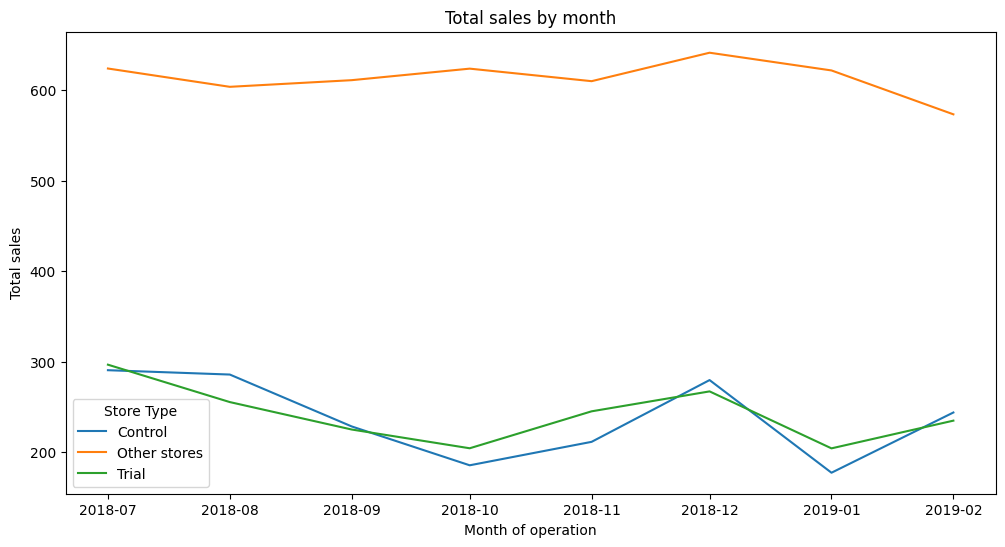

In [ ]:
# Visual checks on trends based on the drivers
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores"))
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_sales = past_sales[past_sales["YEARMONTH"] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x="TransactionMonth", y="totSales", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend(title="Store Type")
plt.show()

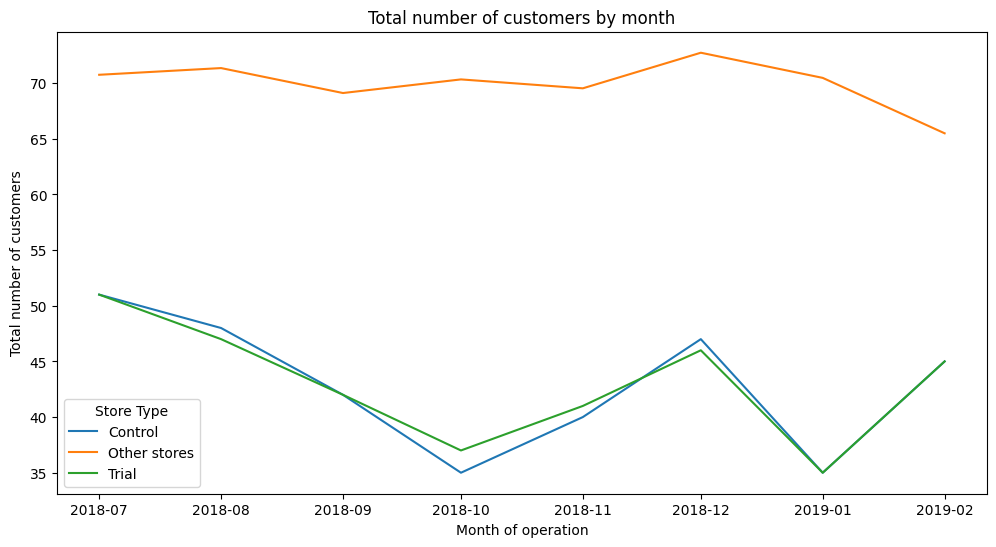

In [ ]:
# Visual checks on trends based on the number of customers
measure_over_time_custs = measure_over_time.copy()
measure_over_time_custs["Store_type"] = measure_over_time_custs["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores"))
past_customers = measure_over_time_custs.groupby(["YEARMONTH", "Store_type"]).agg(numberCustomers=("nCustomers", "mean")).reset_index()
past_customers["TransactionMonth"] = pd.to_datetime(past_customers["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_customers = past_customers[past_customers["YEARMONTH"] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x="TransactionMonth", y="numberCustomers", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title="Store Type")
plt.show()

**Assessment of trial**

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
pre_trial_sales_trial = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902),
    "totSales"
].sum()

pre_trial_sales_control = pre_trial_measures.loc[
    (pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902),
    "totSales"
].sum()

scaling_factor_for_control_sales = pre_trial_sales_trial / pre_trial_sales_control

# Apply the scaling factor
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales.loc[
    measure_over_time_sales["STORE_NBR"] == control_store, "controlSales"
] = measure_over_time_sales.loc[
    measure_over_time_sales["STORE_NBR"] == control_store, "totSales"
] * scaling_factor_for_control_sales


In [ ]:

# Calculate the percentage difference between scaled control sales and trial sales
percentage_diff = measure_over_time_sales.loc[
    measure_over_time_sales["STORE_NBR"] == control_store,
    ["YEARMONTH", "controlSales"]
].merge(
    measure_over_time.loc[
        measure_over_time["STORE_NBR"] == trial_store,
        ["YEARMONTH", "totSales"]
    ],
    on="YEARMONTH"
)

percentage_diff["percentageDiff"] = abs(percentage_diff["controlSales"] - percentage_diff["totSales"]) / percentage_diff["controlSales"]


#### As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period

In [ ]:

# Calculate standard deviation of percentage difference in the pre-trial period
std_dev = percentage_diff.loc[percentage_diff["YEARMONTH"] < 201902, "percentageDiff"].std()

# Define degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period -> 8 - 1 = 7

# Calculate t-values for each month in the trial period
percentage_diff["tValue"] = percentage_diff["percentageDiff"] / std_dev

# Convert YEARMONTH to datetime format
percentage_diff["TransactionMonth"] = pd.to_datetime(percentage_diff["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Filter for trial period (Feb 2019 - Apr 2019)
test_results = percentage_diff.loc[(percentage_diff["YEARMONTH"] < 201905) & (percentage_diff["YEARMONTH"] > 201901), ["TransactionMonth", "tValue"]]

print(test_results)

  TransactionMonth     tValue
7       2019-02-01   1.183534
8       2019-03-01   7.339116
9       2019-04-01  12.476373


In [ ]:
# Define degrees of freedom
import scipy.stats as stats
degrees_of_freedom = 7  # 8 months in pre-trial period -> 8 - 1 = 7

# Calculate the 95th percentile of the t-distribution
critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

print(f"95th percentile of t-distribution with {degrees_of_freedom} degrees of freedom: {critical_t_value}")


95th percentile of t-distribution with 7 degrees of freedom: 1.894578605061305


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

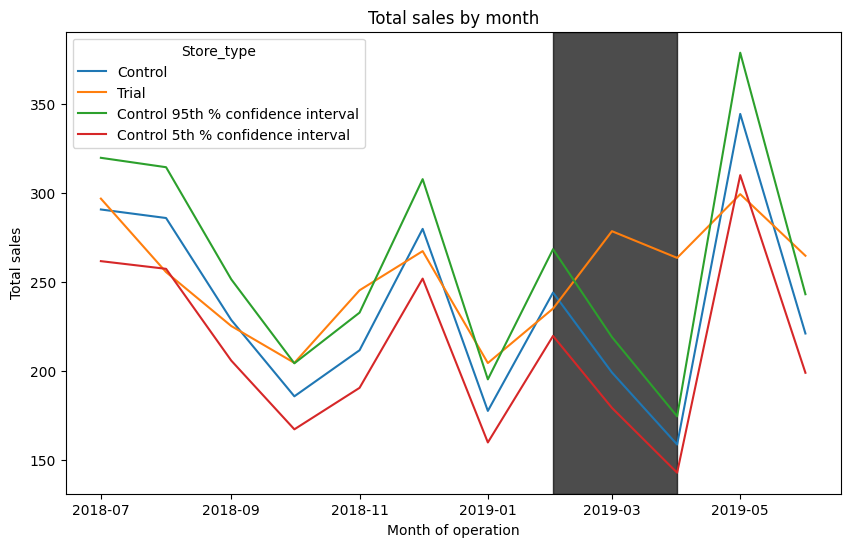

In [ ]:
# Define degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period -> 8 - 1 = 7

# Calculate the 95th percentile of the t-distribution
critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

# Trial and control store total sales
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_sales = past_sales[past_sales["Store_type"].isin(["Trial", "Control"])]

# Control store 95th and 5th percentiles
past_sales_controls_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_95["totSales"] *= (1 + std_dev * 2)
past_sales_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_controls_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_5["totSales"] *= (1 - std_dev * 2)
past_sales_controls_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

# Define trial period for shading
trial_start = pd.to_datetime("20190201", format="%Y%m%d")
trial_end = pd.to_datetime("20190401", format="%Y%m%d")

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", linewidth=1.5)

# Highlighting trial period
plt.axvspan(trial_start, trial_end, color='black', alpha=0.7)  # Darker shading for better visibility

# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")

# Adjust legend formatting
plt.legend(title="Store_type", loc="best", frameon=True)

# Display plot
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
#

In [ ]:
 #Filter pre-trial data for trial and control stores
trial_pretrial_customers = pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) &
                                            (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()

control_pretrial_customers = pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) &
                                              (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()

# Compute scaling factor
scalingFactorForControlCust = trial_pretrial_customers / control_pretrial_customers

measureOverTimeCusts = measure_over_time.copy()

# Apply scaling factor to control store customers
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust
)

# Label store types
measureOverTimeCusts["Store_type"] = measureOverTimeCusts["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)
# Merge scaled control customers with trial store customers
merged_customers = measureOverTimeCusts[["YEARMONTH", "STORE_NBR", "nCustomers", "controlCustomers"]].copy()

# Filter only trial store data for merging
trial_customers = measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]]

# Merge datasets on YEARMONTH
merged_customers = pd.merge(
    trial_customers,
    measureOverTimeCusts[["YEARMONTH", "controlCustomers"]],
    on="YEARMONTH"
)
# Calculate percentage difference
merged_customers["percentageDiff"] = abs(merged_customers["controlCustomers"] - merged_customers["nCustomers"]) / merged_customers["controlCustomers"]


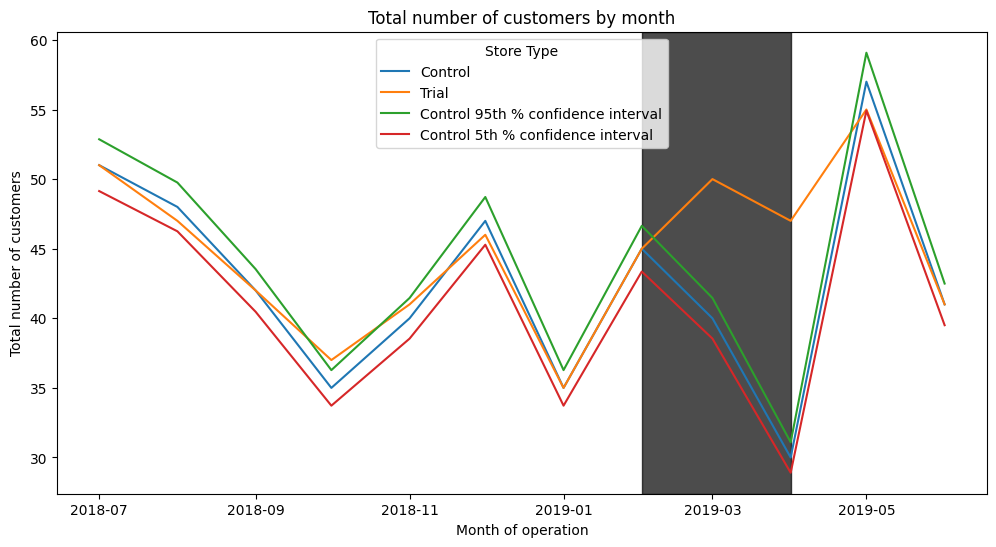

In [ ]:
# Standard deviation of percentageDiff for pre-trial period
std_dev = merged_customers[merged_customers["YEARMONTH"] < 201902]["percentageDiff"].std()

# Define degrees of freedom
degrees_of_freedom = 7  # (8 months in pre-trial period → 8 - 1 = 7)
# Compute mean number of customers per month by store type
past_customers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"], as_index=False).agg(nCusts=("nCustomers", "mean"))

# Keep only Trial and Control stores
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]
# Compute 95th percentile
past_customers_95 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_95["nCusts"] *= (1 + std_dev * 2)
past_customers_95["Store_type"] = "Control 95th % confidence interval"

# Compute 5th percentile
past_customers_5 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_5["nCusts"] *= (1 - std_dev * 2)
past_customers_5["Store_type"] = "Control 5th % confidence interval"


# Combine all datasets for plotting
trial_assessment = pd.concat([past_customers, past_customers_95, past_customers_5])

# Convert YEARMONTH to datetime format for better plotting
trial_assessment["TransactionMonth"] = pd.to_datetime(trial_assessment["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="nCusts", hue="Store_type")

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(pd.to_datetime("20190201"), pd.to_datetime("20190401"), color='black', alpha=0.7)

plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title="Store Type")
plt.show()


Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial
stores.

**TRIAL STORE 86**

In [ ]:
measureOverTime = data.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),
    nCustomers=("LYLTY_CARD_NBR", pd.Series.nunique),
    nTxnPerCust=("TXN_ID", lambda x: x.nunique() / data.loc[x.index, "LYLTY_CARD_NBR"].nunique()),
    nChipsPerTxn=("PROD_QTY", lambda x: x.sum() / data.loc[x.index, "TXN_ID"].nunique()),
    avgPricePerUnit=("TOT_SALES", lambda x: x.sum() / data.loc[x.index, "PROD_QTY"].sum())
).reset_index().sort_values(by=["STORE_NBR", "YEARMONTH"])


In [ ]:
# Use the functions for calculating correlation
trial_store = 86  # Define the trial store

# Calculate correlation for total sales and number of customers
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)


In [ ]:
# Use the functions for calculating magnitude
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)


In [ ]:
# Create a combined score composed of correlation and magnitude
corr_weight = 0.5

# Merge correlation and magnitude DataFrames for sales
score_nSales = corr_nSales.merge(magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = score_nSales["corr_measure"] * corr_weight + score_nSales["mag_measure"] * (1 - corr_weight)

# Merge correlation and magnitude DataFrames for number of customers
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = score_nCustomers["corr_measure"] * corr_weight + score_nCustomers["mag_measure"] * (1 - corr_weight)


In [ ]:
# Merge sales and customer score dataframes
score_Control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"])
# Calculate the final control score as an average of sales and customer scores
score_Control["finalControlScore"] = score_Control["scoreNSales"] * 0.5 + score_Control["scoreNCust"] * 0.5
# Filter for the trial store and sort by finalControlScore in descending order
best_match = score_Control[score_Control["Store1"] == trial_store].sort_values(
    by="finalControlScore", ascending=False
)

# Select the second highest score (to exclude trial_store itself)
control_store = best_match.iloc[1]["Store2"]
print(f"Selected Control Store: {control_store}")


Selected Control Store: 155.0


Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial.
We’ll look at total sales first.

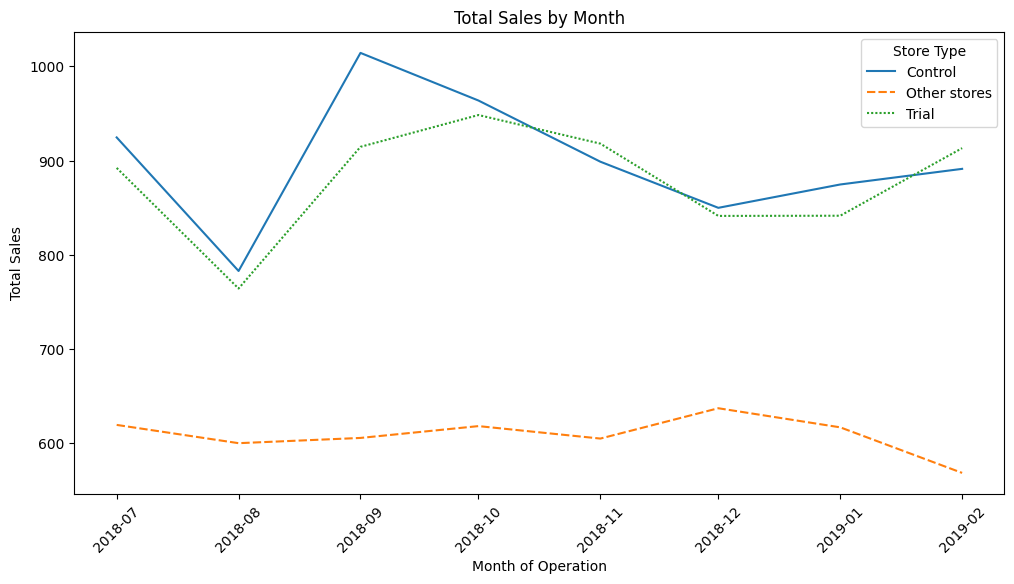

In [ ]:
# Visual checks on trends based on the drivers
measureOverTimeSales = measureOverTime.copy()

# Assign Store Type based on trial and control stores
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)

# Aggregate total sales by month and store type
pastSales = measureOverTimeSales.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales=("totSales", "mean")
).reset_index()

# Convert YEARMONTH to a date format
pastSales["TransactionMonth"] = pd.to_datetime(pastSales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Filter pre-trial period
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastSales, x="TransactionMonth", y="totSales", hue="Store_type", style="Store_type")

plt.xlabel("Month of Operation")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

Great, sales are trending in a similar way.
Next, number of customers.

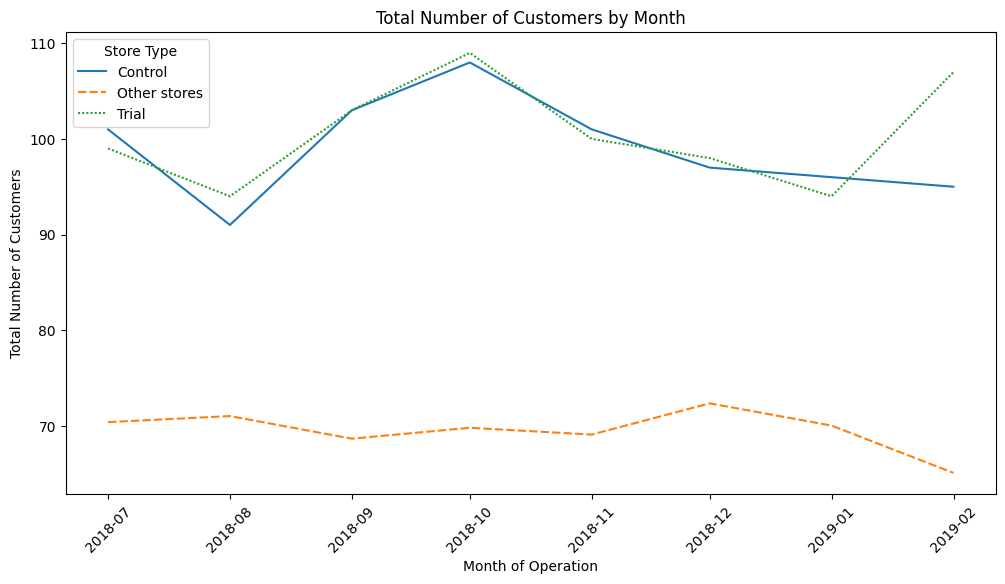

In [ ]:
measureOverTimeCusts = measureOverTime.copy()

# Assign Store Type based on trial and control stores
measureOverTimeCusts["Store_type"] = measureOverTimeCusts["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)

# Aggregate number of customers by month and store type
pastCustomers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"]).agg(
    numberCustomers=("nCustomers", "mean")
).reset_index()

# Convert YEARMONTH to a date format
pastCustomers["TransactionMonth"] = pd.to_datetime(pastCustomers["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Filter pre-trial period
pastCustomers = pastCustomers[pastCustomers["YEARMONTH"] < 201903]
plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCustomers, x="TransactionMonth", y="numberCustomers", hue="Store_type", style="Store_type")

plt.xlabel("Month of Operation")
plt.ylabel("Total Number of Customers")
plt.title("Total Number of Customers by Month")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.show()

Good, the trend in number of customers is also similar.
Let’s now assess the impact of the trial on sales.

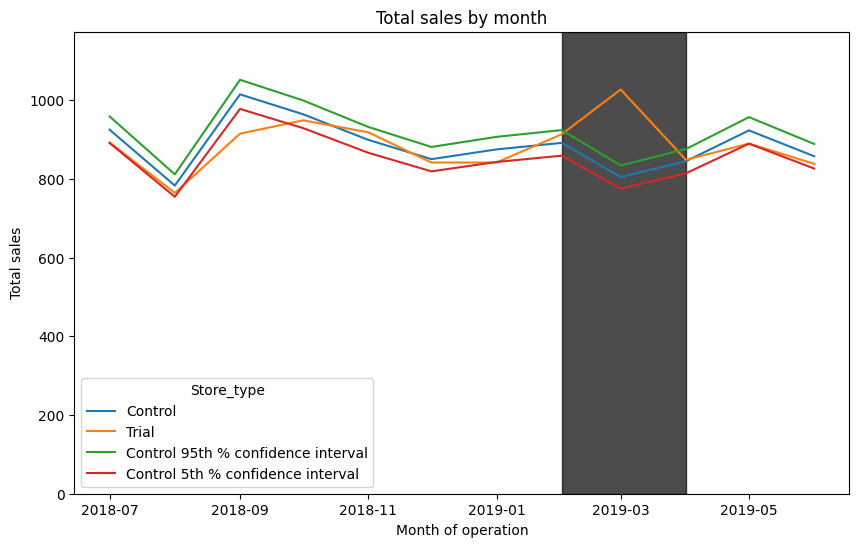

In [ ]:
# Define degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period -> 8 - 1 = 7

# Calculate the 95th percentile of the t-distribution
critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

# Trial and control store total sales
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_sales = past_sales[past_sales["Store_type"].isin(["Trial", "Control"])]

# Control store 95th and 5th percentiles
past_sales_controls_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_95["totSales"] *= (1 + std_dev * 2)
past_sales_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_controls_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_5["totSales"] *= (1 - std_dev * 2)
past_sales_controls_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

# Define trial period for shading
trial_start = pd.to_datetime("20190201", format="%Y%m%d")
trial_end = pd.to_datetime("20190401", format="%Y%m%d")

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", linewidth=1.5)

# Highlighting trial period
plt.axvspan(trial_start, trial_end, color='black', alpha=0.7)  # Darker shading for better visibility
# Set Y-axis to start at zero
plt.ylim(0, max(trialAssessment["totSales"]) * 1.1)
# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")

# Adjust legend formatting
plt.legend(title="Store_type", loc="best", frameon=True)

# Display plot
plt.show()


The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.


Let’s have a look at assessing this for number of customers as well.

In [ ]:
 #Filter pre-trial data for trial and control stores
trial_pretrial_customers = pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) &
                                            (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()

control_pretrial_customers = pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) &
                                              (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()

# Compute scaling factor
scalingFactorForControlCust = trial_pretrial_customers / control_pretrial_customers

measureOverTimeCusts = measure_over_time.copy()

# Apply scaling factor to control store customers
measureOverTimeCusts.loc[measureOverTimeCusts["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts["nCustomers"] * scalingFactorForControlCust
)

# Label store types
measureOverTimeCusts["Store_type"] = measureOverTimeCusts["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)
# Merge scaled control customers with trial store customers
merged_customers = measureOverTimeCusts[["YEARMONTH", "STORE_NBR", "nCustomers", "controlCustomers"]].copy()

# Filter only trial store data for merging
trial_customers = measureOverTimeCusts[measureOverTimeCusts["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]]

# Merge datasets on YEARMONTH
merged_customers = pd.merge(
    trial_customers,
    measureOverTimeCusts[["YEARMONTH", "controlCustomers"]],
    on="YEARMONTH"
)
# Calculate percentage difference
merged_customers["percentageDiff"] = abs(merged_customers["controlCustomers"] - merged_customers["nCustomers"]) / merged_customers["controlCustomers"]


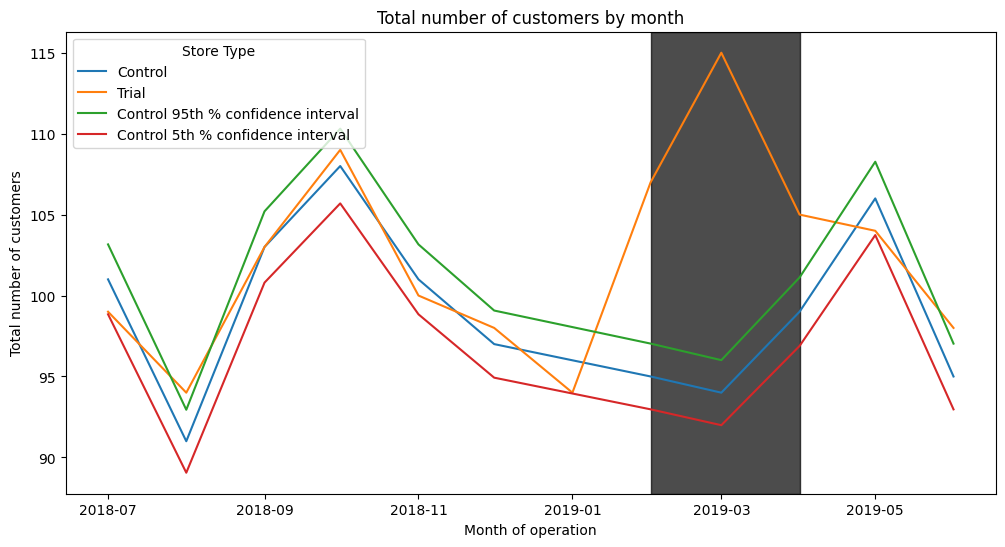

In [ ]:
# Standard deviation of percentageDiff for pre-trial period
std_dev = merged_customers[merged_customers["YEARMONTH"] < 201902]["percentageDiff"].std()

# Define degrees of freedom
degrees_of_freedom = 7  # (8 months in pre-trial period → 8 - 1 = 7)
# Compute mean number of customers per month by store type
past_customers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"], as_index=False).agg(nCusts=("nCustomers", "mean"))

# Keep only Trial and Control stores
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]
# Compute 95th percentile
past_customers_95 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_95["nCusts"] *= (1 + std_dev * 2)
past_customers_95["Store_type"] = "Control 95th % confidence interval"

# Compute 5th percentile
past_customers_5 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_5["nCusts"] *= (1 - std_dev * 2)
past_customers_5["Store_type"] = "Control 5th % confidence interval"


# Combine all datasets for plotting
trial_assessment = pd.concat([past_customers, past_customers_95, past_customers_5])

# Convert YEARMONTH to datetime format for better plotting
trial_assessment["TransactionMonth"] = pd.to_datetime(trial_assessment["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="nCusts", hue="Store_type")

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(pd.to_datetime("20190201"), pd.to_datetime("20190401"), color='black', alpha=0.7)


plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title="Store Type")
plt.show()


It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

**TRIAL STORE 88**

In [ ]:
# Aggregation to compute required measures
measureOverTime = (
    data.groupby(["STORE_NBR", "YEARMONTH"])
    .agg(
        totSales=pd.NamedAgg(column="TOT_SALES", aggfunc="sum"),
        nCustomers=pd.NamedAgg(column="LYLTY_CARD_NBR", aggfunc=pd.Series.nunique),
        nTxnPerCust=pd.NamedAgg(column="TXN_ID", aggfunc=lambda x: x.nunique() / data.loc[x.index, "LYLTY_CARD_NBR"].nunique()),
        nChipsPerTxn=pd.NamedAgg(column="PROD_QTY", aggfunc=lambda x: x.sum() / x.nunique()),
        avgPricePerUnit=pd.NamedAgg(column="TOT_SALES", aggfunc=lambda x: x.sum() / data.loc[x.index, "PROD_QTY"].sum())
    )
    .reset_index()
    .sort_values(by=["STORE_NBR", "YEARMONTH"])
)

In [ ]:
#### Use the functions for calculating correlation
trial_store = 88

# Calculate correlation for total sales and number of customers
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

# Use the functions for calculating magnitude distance
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

# Example usage output
print(corr_nSales.head())
print(magnitude_nSales.head())

   Store1  Store2  corr_measure
0      88       1      0.813636
1      88       2     -0.067927
2      88       3     -0.507847
3      88       4     -0.745566
4      88       5      0.190330
   Store1  Store2  mag_measure
0      88       1     0.142830
1      88       2     0.115895
2      88       3     0.802803
3      88       4     0.897661
4      88       5     0.610161


In [ ]:
# Create a combined score composed of correlation and magnitude
def create_combined_score(corr_df, mag_df, weight=0.5):
    merged_df = corr_df.merge(mag_df, on=["Store1", "Store2"], how="inner")
    merged_df["combined_score"] = merged_df["corr_measure"] * weight + merged_df["mag_measure"] * (1 - weight)
    return merged_df

# Compute final scores
score_nSales = create_combined_score(corr_nSales, magnitude_nSales)
score_nCustomers = create_combined_score(corr_nCustomers, magnitude_nCustomers)

# Example usage output
print(score_nSales.head())
print(score_nCustomers.head())


   Store1  Store2  corr_measure  mag_measure  combined_score
0      88       1      0.813636     0.142830        0.478233
1      88       2     -0.067927     0.115895        0.023984
2      88       3     -0.507847     0.802803        0.147478
3      88       4     -0.745566     0.897661        0.076047
4      88       5      0.190330     0.610161        0.400245
   Store1  Store2  corr_measure  mag_measure  combined_score
0      88       1      0.305334     0.351219        0.328277
1      88       2     -0.452379     0.300329       -0.076025
2      88       3      0.522884     0.843685        0.683284
3      88       4     -0.361503     0.924507        0.281502
4      88       5     -0.025320     0.737229        0.355955


In [ ]:
# Combine scores across drivers
score_Control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"], how="inner")
score_Control["finalControlScore"] = score_Control["combined_score_x"] * 0.5 + score_Control["combined_score_y"] * 0.5

# Example usage output
print(score_Control.head())

   Store1  Store2  corr_measure_x  mag_measure_x  combined_score_x  \
0      88       1        0.813636       0.142830          0.478233   
1      88       2       -0.067927       0.115895          0.023984   
2      88       3       -0.507847       0.802803          0.147478   
3      88       4       -0.745566       0.897661          0.076047   
4      88       5        0.190330       0.610161          0.400245   

   corr_measure_y  mag_measure_y  combined_score_y  finalControlScore  
0        0.305334       0.351219          0.328277           0.403255  
1       -0.452379       0.300329         -0.076025          -0.026020  
2        0.522884       0.843685          0.683284           0.415381  
3       -0.361503       0.924507          0.281502           0.178775  
4       -0.025320       0.737229          0.355955           0.378100  


In [ ]:
# Select control stores based on the highest matching store (excluding itself)
def select_control_store(score_df, trial_store):
    trial_scores = score_df[score_df["Store1"] == trial_store].copy()
    trial_scores = trial_scores.sort_values(by="finalControlScore", ascending=False)
    control_store = trial_scores.iloc[1]["Store2"]  # Select second highest store
    return control_store

# Select control store for trial store 77
control_store = select_control_store(score_Control, trial_store)
print(f"Selected control store for trial store {trial_store}: {control_store}")

Selected control store for trial store 88: 237.0


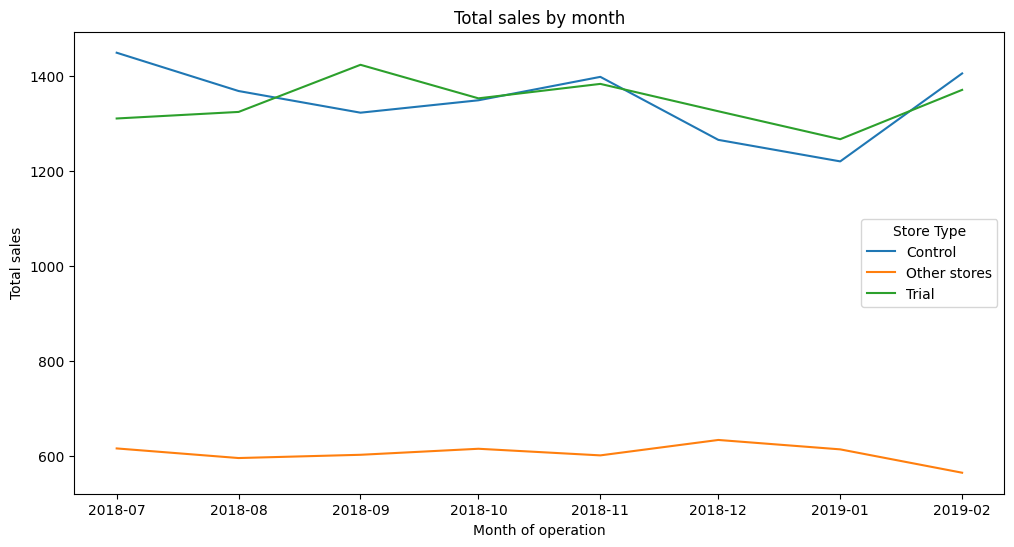

In [ ]:
# Visual checks on trends based on the drivers
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores"))
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_sales = past_sales[past_sales["YEARMONTH"] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x="TransactionMonth", y="totSales", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend(title="Store Type")
plt.show()

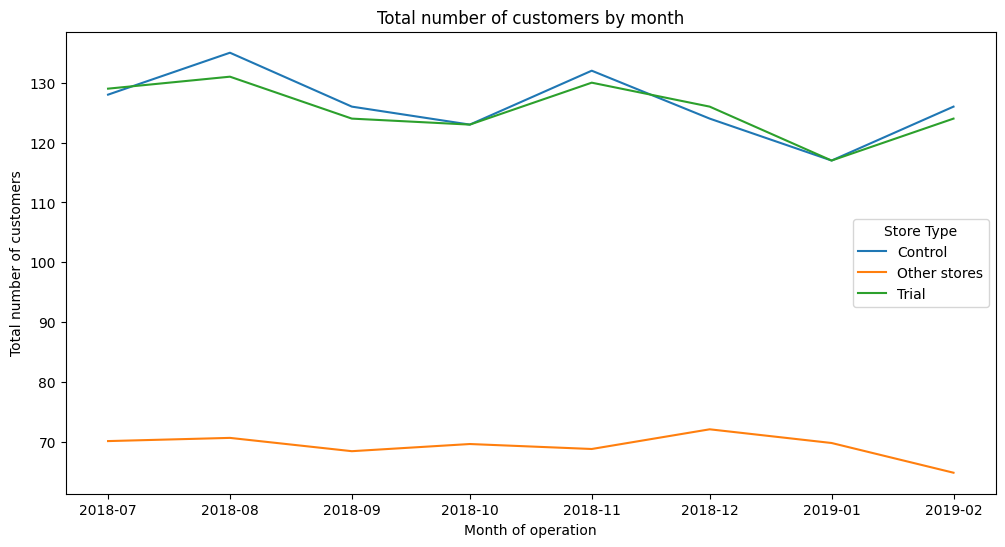

In [ ]:
# Visual checks on trends based on the number of customers
measure_over_time_custs = measure_over_time.copy()
measure_over_time_custs["Store_type"] = measure_over_time_custs["STORE_NBR"].apply(lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores"))
past_customers = measure_over_time_custs.groupby(["YEARMONTH", "Store_type"]).agg(numberCustomers=("nCustomers", "mean")).reset_index()
past_customers["TransactionMonth"] = pd.to_datetime(past_customers["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_customers = past_customers[past_customers["YEARMONTH"] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x="TransactionMonth", y="numberCustomers", hue="Store_type")
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title="Store Type")
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well

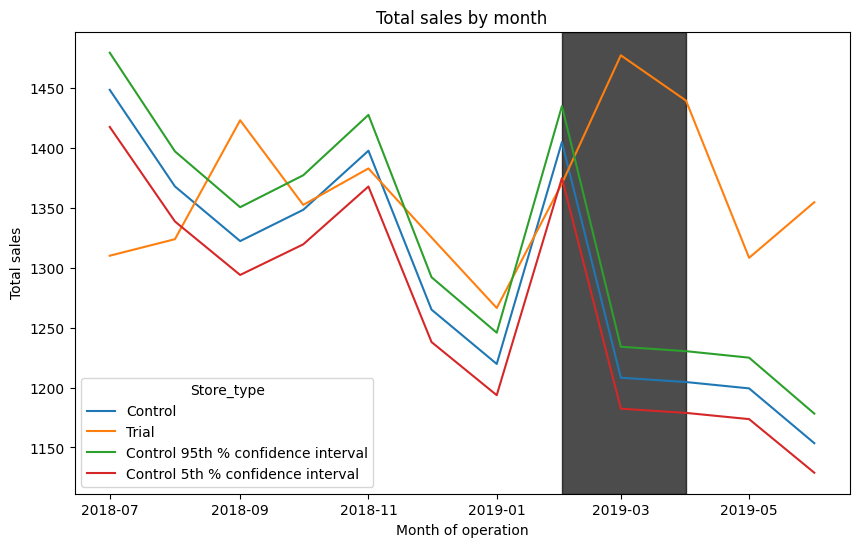

In [ ]:
# Define degrees of freedom
degrees_of_freedom = 7  # 8 months in pre-trial period -> 8 - 1 = 7

# Calculate the 95th percentile of the t-distribution
critical_t_value = stats.t.ppf(0.95, df=degrees_of_freedom)

# Trial and control store total sales
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
)
past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(totSales=("totSales", "mean")).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str) + "01", format="%Y%m%d")
past_sales = past_sales[past_sales["Store_type"].isin(["Trial", "Control"])]

# Control store 95th and 5th percentiles
past_sales_controls_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_95["totSales"] *= (1 + std_dev * 2)
past_sales_controls_95["Store_type"] = "Control 95th % confidence interval"

past_sales_controls_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_controls_5["totSales"] *= (1 - std_dev * 2)
past_sales_controls_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

# Define trial period for shading
trial_start = pd.to_datetime("20190201", format="%Y%m%d")
trial_end = pd.to_datetime("20190401", format="%Y%m%d")

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="totSales", hue="Store_type", linewidth=1.5)

# Highlighting trial period
plt.axvspan(trial_start, trial_end, color='black', alpha=0.7)  # Darker shading for better visibility
# Set Y-axis to start at zero
#plt.ylim(0, max(trialAssessment["totSales"]) * 1.1)
# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")

# Adjust legend formatting
plt.legend(title="Store_type", loc="best", frameon=True)

# Display plot
plt.show()


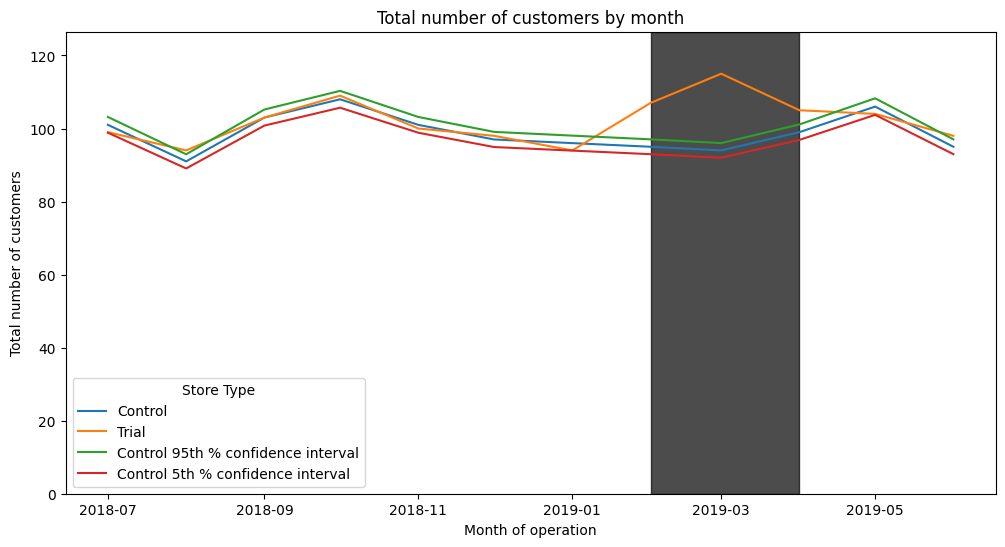

In [ ]:
# Standard deviation of percentageDiff for pre-trial period
std_dev = merged_customers[merged_customers["YEARMONTH"] < 201902]["percentageDiff"].std()

# Define degrees of freedom
degrees_of_freedom = 7  # (8 months in pre-trial period → 8 - 1 = 7)
# Compute mean number of customers per month by store type
past_customers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"], as_index=False).agg(nCusts=("nCustomers", "mean"))

# Keep only Trial and Control stores
past_customers = past_customers[past_customers["Store_type"].isin(["Trial", "Control"])]
# Compute 95th percentile
past_customers_95 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_95["nCusts"] *= (1 + std_dev * 2)
past_customers_95["Store_type"] = "Control 95th % confidence interval"

# Compute 5th percentile
past_customers_5 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_customers_5["nCusts"] *= (1 - std_dev * 2)
past_customers_5["Store_type"] = "Control 5th % confidence interval"


# Combine all datasets for plotting
trial_assessment = pd.concat([past_customers, past_customers_95, past_customers_5])

# Convert YEARMONTH to datetime format for better plotting
trial_assessment["TransactionMonth"] = pd.to_datetime(trial_assessment["YEARMONTH"].astype(str) + "01", format="%Y%m%d")

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment, x="TransactionMonth", y="nCusts", hue="Store_type")

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(pd.to_datetime("20190201"), pd.to_datetime("20190401"), color='black', alpha=0.7)
plt.ylim(0, max(trial_assessment["nCusts"]) * 1.1)

plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title="Store Type")
plt.show()


Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

**Conclusion**

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
we have finished our analysis, we can prepare our presentation to the Category Manager.